In [1]:
import pandas as pd
import numpy as np
from scipy import stats

def load_and_process_data():
    # Read CSV
    df = pd.read_csv('/content/Co2.csv', encoding='utf-8-sig')

    # Get numeric columns (excluding first column)
    numeric_cols = df.columns[1:]

    # Convert to numeric, handle missing values
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Fill NaN with 0 for emission data
    df[numeric_cols] = df[numeric_cols].fillna(0)

    # Remove outliers
    for col in numeric_cols:
        z_scores = np.abs(stats.zscore(df[col], nan_policy='omit'))
        df.loc[z_scores > 3, col] = df[col].median()

    return df

def prepare_time_series(df):
    years = sorted(list(set([col[:4] for col in df.columns if col != '구분(1)'])))
    results = []

    for _, row in df.iterrows():
        region = row['구분(1)']
        for year in years:
            year_cols = [col for col in df.columns if col.startswith(year)]
            if year_cols:
                year_data = row[year_cols]
                total = year_data.sum()
                results.append({
                    'Region': region,
                    'Year': int(year),
                    'Total_Emissions': total
                })

    results_df = pd.DataFrame(results)

    # Add descriptive statistics
    results_df['YoY_Change'] = results_df.groupby('Region')['Total_Emissions'].pct_change()

    return results_df

# Execute
raw_data = load_and_process_data()
time_series = prepare_time_series(raw_data)

print("Data Shape:", raw_data.shape)
print("\nMissing Values:", raw_data.isnull().sum().sum())
print("\nSummary Statistics by Region:")
summary = time_series.groupby('Region').agg({
    'Total_Emissions': ['mean', 'std', 'min', 'max'],
    'YoY_Change': 'mean'
}).round(2)
print(summary.head())

Data Shape: (25, 207)

Missing Values: 0

Summary Statistics by Region:
           Total_Emissions                                        YoY_Change
                      mean          std          min          max       mean
Region                                                                      
강원도           7.082153e+07  14623153.07   48887773.0   97714082.0       0.02
경기도           2.634773e+08  30605739.64  195177189.0  307328708.0      -0.01
경상남도          1.043800e+08   9797080.54   78675502.0  126698878.0       0.00
경상북도          1.356830e+08  31244286.92   94285521.0  195179971.0       0.03
광양 특별 대책지역    1.731671e+06   8304801.54          0.0   39828429.0        inf


Historical Annual Growth Rate: -1.05%
R² Score: 0.306

Predicted Emissions (Million units):
2022: 1417.51
2023: 1405.67
2024: 1393.84
2025: 1382.00
2026: 1370.17
2027: 1358.33
2028: 1346.49
2029: 1334.66
2030: 1322.82
2031: 1310.99
2032: 1299.15
2033: 1287.32
2034: 1275.48
2035: 1263.65


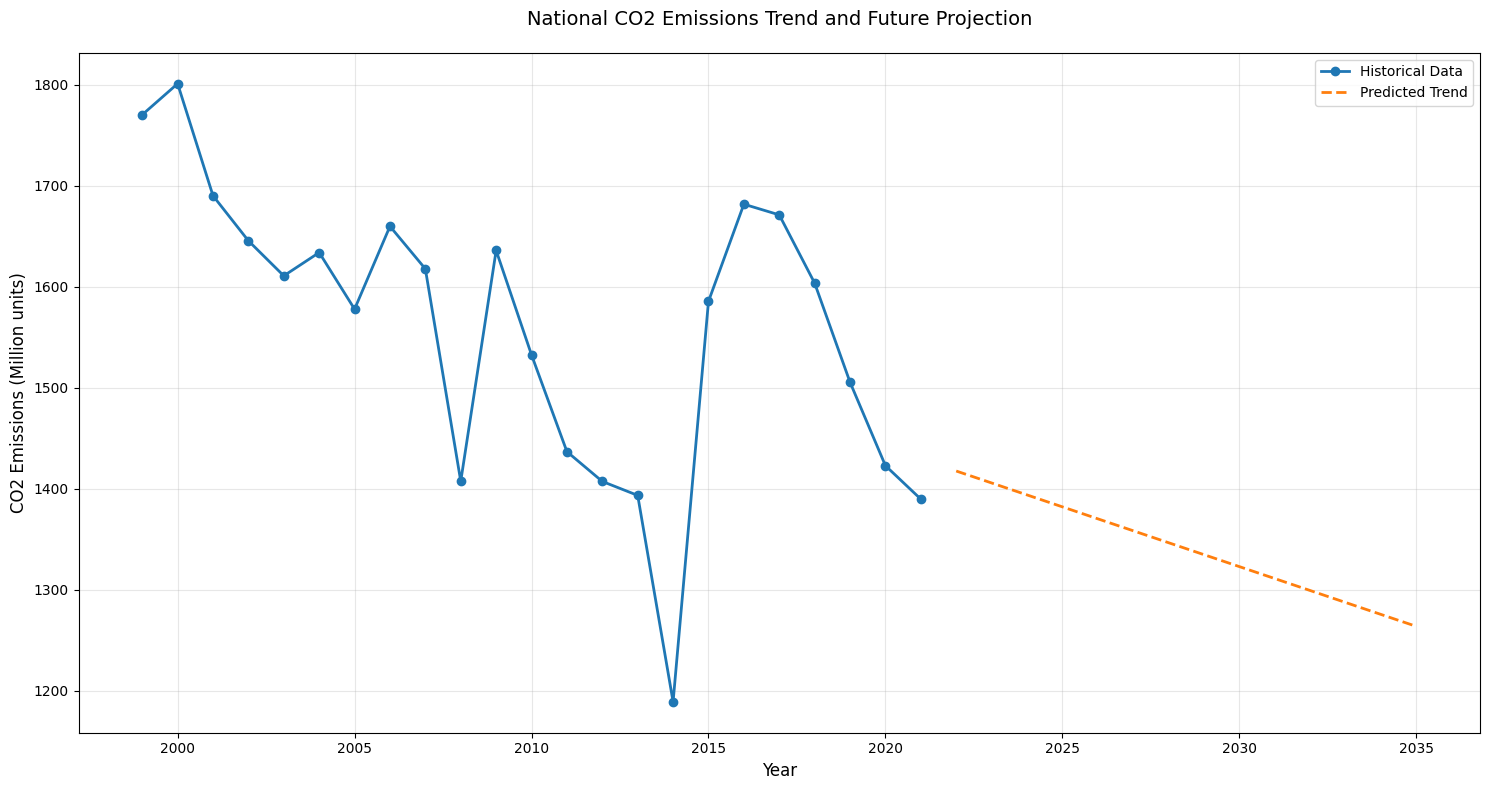

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
plt.style.use('default')

# 데이터 로드 및 처리
df = pd.read_csv('/content/Co2.csv', encoding='utf-8-sig')
numeric_cols = df.columns[1:]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# 시계열 데이터 준비
years = sorted(list(set([col[:4] for col in df.columns if col != '구분(1)'])))
national_data = []

for year in years:
    year_cols = [col for col in df.columns if col.startswith(year)]
    total = df[df['구분(1)'] == '전국'][year_cols].values[0].sum()
    national_data.append({
        'Year': int(year),
        'Total_Emissions': total
    })

national_df = pd.DataFrame(national_data)

# 예측을 위한 데이터 준비
X = national_df['Year'].values.reshape(-1, 1)
y = national_df['Total_Emissions'].values

# 모델 생성 및 학습
model = LinearRegression()
model.fit(X, y)

# 미래 예측 생성 (2031년부터 2035년까지 확장)
future_years = np.array(range(2022, 2036)).reshape(-1, 1)  # 2031을 2036으로 변경하여 2035년까지 포함
future_predictions = model.predict(future_years)

# 그래프 그리기
plt.figure(figsize=(15, 8))

# 과거 데이터
plt.plot(national_df['Year'], national_df['Total_Emissions'] / 1e6,
         marker='o', label='Historical Data', linewidth=2)

# 미래 예측
plt.plot(future_years, future_predictions / 1e6,
         '--', label='Predicted Trend', linewidth=2)

plt.title('National CO2 Emissions Trend and Future Projection', fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('CO2 Emissions (Million units)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# 통계 계산
total_years = len(national_df['Year'])
total_growth = (national_df['Total_Emissions'].iloc[-1] / national_df['Total_Emissions'].iloc[0]) - 1
annual_growth_rate = (1 + total_growth) ** (1/total_years) - 1

print(f"Historical Annual Growth Rate: {annual_growth_rate*100:.2f}%")
print(f"R² Score: {r2_score(y, model.predict(X)):.3f}")
print("\nPredicted Emissions (Million units):")
for year, pred in zip(future_years.flatten(), future_predictions):
    print(f"{year}: {pred/1e6:.2f}")

plt.tight_layout()
plt.show()


Historical Data (Million units):
2017: 1671.19
2018: 1603.59
2019: 1505.43
2020: 1422.80
2021: 1389.63

Future Predictions (Million units):
2022: 1417.51
2023: 1405.67
2024: 1393.84
2025: 1382.00
2026: 1370.17
2027: 1358.33
2028: 1346.49
2029: 1334.66
2030: 1322.82

Historical Average Annual Growth Rate: -1.05%


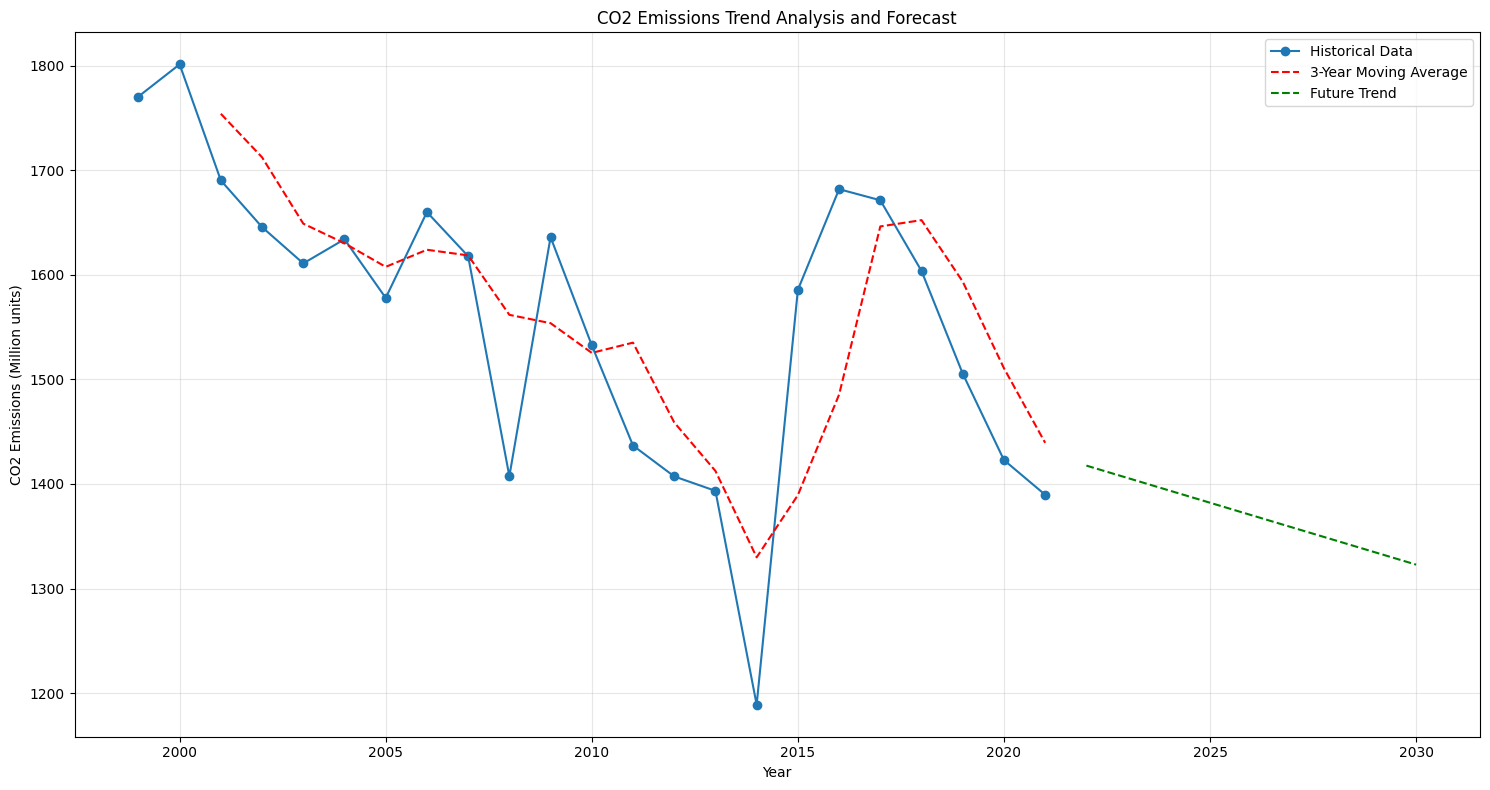

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load and process data
df = pd.read_csv('/content/Co2.csv', encoding='utf-8-sig')
numeric_cols = df.columns[1:]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Get national data by year
years = []
emissions = []
national_data = df[df['구분(1)'] == '전국'].iloc[0]

for year in range(1999, 2022):
    year_cols = [col for col in df.columns if str(year) in col]
    if year_cols:
        years.append(year)
        emissions.append(national_data[year_cols].sum())

# Convert to numpy arrays
years = np.array(years)
emissions = np.array(emissions)

# Calculate trend
slope, intercept, r_value, p_value, std_err = linregress(years, emissions)

# Future predictions
future_years = np.array(range(2022, 2031))
trend = slope * future_years + intercept

# Plot
plt.figure(figsize=(15, 8))

# Historical data
plt.plot(years, emissions / 1e6, 'o-', label='Historical Data')

# Moving average
window = 3
ma = pd.Series(emissions).rolling(window=window).mean()
plt.plot(years, ma / 1e6, 'r--', label=f'{window}-Year Moving Average')

# Future trend
plt.plot(future_years, trend / 1e6, 'g--', label='Future Trend')

plt.title('CO2 Emissions Trend Analysis and Forecast')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (Million units)')
plt.grid(True, alpha=0.3)
plt.legend()

# Print statistics
print(f"Historical Data (Million units):")
for y, e in zip(years[-5:], emissions[-5:]):
    print(f"{y}: {e/1e6:.2f}")

print(f"\nFuture Predictions (Million units):")
for y, t in zip(future_years, trend):
    print(f"{y}: {t/1e6:.2f}")

avg_growth = (emissions[-1]/emissions[0])**(1/len(years)) - 1
print(f"\nHistorical Average Annual Growth Rate: {avg_growth*100:.2f}%")

plt.tight_layout()
plt.show()